In [1]:
import torch
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi


Using device: Tesla T4
CUDA available: True
Wed Nov 26 11:57:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_dir = "/content/drive/MyDrive/DeepLearningGSLC2/pix2pix/facades/train/"
val_dir     = "/content/drive/MyDrive/DeepLearningGSLC2/pix2pix/facades/val/"
test_dir    = "/content/drive/MyDrive/DeepLearningGSLC2/pix2pix/facades/test/"

In [4]:
import os
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [5]:
# split gambar menjadi input dan output
class FacadeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith(".jpg") or f.endswith(".png")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(file_path).convert("RGB")

        w, h = img.size
        w2 = w // 2

        # LEFT = input, RIGHT = target
        input_img = img.crop((0, 0, w2, h))
        target_img = img.crop((w2, 0, w, h))

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

In [6]:
# transformasi data
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = FacadeDataset(dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# train_dataset = FacadeDataset(dataset_dir, transform=transform)
# val_dataset   = FacadeDataset(val_dir, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [7]:
# U-NET generator
class UNetBlockDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class GeneratorUNet(nn.Module):
    def __init__(self,):
        super().__init__()

        # Encoder (down)
        self.d1 = UNetBlockDown(3, 64, normalize=False)
        self.d2 = UNetBlockDown(64, 128)
        self.d3 = UNetBlockDown(128, 256)
        self.d4 = UNetBlockDown(256, 512)
        self.d5 = UNetBlockDown(512, 512)
        self.d6 = UNetBlockDown(512, 512)
        self.d7 = UNetBlockDown(512, 512)
        self.d8 = UNetBlockDown(512, 512)

        # Decoder (up)
        self.u1 = UNetBlockUp(512, 512, dropout=True)
        self.u2 = UNetBlockUp(1024, 512, dropout=True)
        self.u3 = UNetBlockUp(1024, 512, dropout=True)
        self.u4 = UNetBlockUp(1024, 512)
        self.u5 = UNetBlockUp(1024, 256)
        self.u6 = UNetBlockUp(512, 128)
        self.u7 = UNetBlockUp(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)
        d6 = self.d6(d5)
        d7 = self.d7(d6)
        d8 = self.d8(d7)

        u1 = self.u1(d8)
        u2 = self.u2(torch.cat([u1, d7], 1))
        u3 = self.u3(torch.cat([u2, d6], 1))
        u4 = self.u4(torch.cat([u3, d5], 1))
        u5 = self.u5(torch.cat([u4, d4], 1))
        u6 = self.u6(torch.cat([u5, d3], 1))
        u7 = self.u7(torch.cat([u6, d2], 1))

        return self.final(torch.cat([u7, d1], 1))

# model u-net di pilih karena u-net pada awalnya di buat untuk semantic segmentation, sehingga cocok untuk mapping pixel to pixel. u-net memiliki skip connection sehingga berguna saat downsampling, detail lokal hilang, skip connections memasukan kembali detail ke decode, hasil akhirnya akan lebih tajam, tersturktur dan tisak kabur.

In [ ]:
# # PatchGAN Discriminator: input = (image, target) dikonkaten di channel
# class Discriminator(nn.Module):
#     def __init__(self, in_channels=3):
#         super().__init__()
#         # in_channels*2 karena concat input & target / output
#         def block(in_c, out_c, normalize=True):
#             layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
#             if normalize:
#                 layers.append(nn.BatchNorm2d(out_c))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *block(in_channels * 2, 64, normalize=False),  # (x, y)
#             *block(64, 128),
#             *block(128, 256),
#             *block(256, 512),
#             nn.Conv2d(512, 1, 4, 1, 1)   # output: patch map
#         )

#     def forward(self, x, y):
#         # x: input image, y: target OR generated image
#         xy = torch.cat([x, y], dim=1)
#         return self.model(xy)

In [9]:
# training setup
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using device:", device)

# G = GeneratorUNet().to(device)
# D = Discriminator().to(device)

# criterion_GAN = nn.BCEWithLogitsLoss()
# criterion_L1  = nn.L1Loss()

# # lr G sedikit lebih besar dari D
# optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D = torch.optim.Adam(D.parameters(), lr=0.00005, betas=(0.5, 0.999))

# lambda_L1 = 100

# train_loss_history = []
# val_loss_history   = []

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = GeneratorUNet().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))


Using device: cuda


In [10]:
# training loop
EPOCHS = 100
loss_history = []

# for epoch in range(EPOCHS):
#     G.train()
#     D.train()
#     total_G_l1 = 0.0

#     for inp, tar in train_loader:
#         inp, tar = inp.to(device), tar.to(device)

#         # train discriminator (D)
#         optimizer_D.zero_grad()

#         # real
#         pred_real = D(inp, tar)
#         real_labels = torch.ones_like(pred_real, device=device) * 0.9  # label smoothing
#         loss_D_real = criterion_GAN(pred_real, real_labels)

#         # fake
#         fake = G(inp).detach()
#         pred_fake = D(inp, fake)
#         fake_labels = torch.zeros_like(pred_fake, device=device)  # 0 untuk fake
#         loss_D_fake = criterion_GAN(pred_fake, fake_labels)

#         loss_D = (loss_D_real + loss_D_fake) * 0.5
#         loss_D.backward()
#         optimizer_D.step()

#         # train generator (G)
#         optimizer_G.zero_grad()

#         fake = G(inp)
#         pred_fake_for_G = D(inp, fake)

#         # GAN loss (G ingin D menganggap fake = real)
#         valid_labels = torch.ones_like(pred_fake_for_G, device=device) * 0.9
#         loss_G_GAN = criterion_GAN(pred_fake_for_G, valid_labels)

#         # L1 loss (reconstruction)
#         loss_G_L1 = criterion_L1(fake, tar) * lambda_L1

#         loss_G = loss_G_GAN + loss_G_L1
#         loss_G.backward()
#         optimizer_G.step()

#         total_G_l1 += criterion_L1(fake, tar).item()

#     avg_train_l1 = total_G_l1 / len(train_loader)
#     train_loss_history.append(avg_train_l1)

#     # validation
#     G.eval()
#     val_l1 = 0.0
#     with torch.no_grad():
#         for inp, tar in val_loader:
#             inp, tar = inp.to(device), tar.to(device)
#             fake = G(inp)
#             val_l1 += criterion_L1(fake, tar).item()

#     avg_val_l1 = val_l1 / len(val_loader)
#     val_loss_history.append(avg_val_l1)

#     print(f"Epoch {epoch+1}/{EPOCHS} | Train L1 = {avg_train_l1:.4f} | Val L1 = {avg_val_l1:.4f}")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for i, (inp, tar) in enumerate(dataloader):
        inp, tar = inp.to(device), tar.to(device)

        optimizer.zero_grad()
        output = model(inp)

        loss = criterion(output, tar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss = {avg_loss:.4f}")

Epoch 1/100 | Loss = 0.5071
Epoch 2/100 | Loss = 0.3900
Epoch 3/100 | Loss = 0.3693
Epoch 4/100 | Loss = 0.3580
Epoch 5/100 | Loss = 0.3512
Epoch 6/100 | Loss = 0.3423
Epoch 7/100 | Loss = 0.3369
Epoch 8/100 | Loss = 0.3297
Epoch 9/100 | Loss = 0.3262
Epoch 10/100 | Loss = 0.3183
Epoch 11/100 | Loss = 0.3130
Epoch 12/100 | Loss = 0.3095
Epoch 13/100 | Loss = 0.3002
Epoch 14/100 | Loss = 0.2946
Epoch 15/100 | Loss = 0.2894
Epoch 16/100 | Loss = 0.2809
Epoch 17/100 | Loss = 0.2747
Epoch 18/100 | Loss = 0.2684
Epoch 19/100 | Loss = 0.2629
Epoch 20/100 | Loss = 0.2574
Epoch 21/100 | Loss = 0.2486
Epoch 22/100 | Loss = 0.2406
Epoch 23/100 | Loss = 0.2354
Epoch 24/100 | Loss = 0.2294
Epoch 25/100 | Loss = 0.2222
Epoch 26/100 | Loss = 0.2146
Epoch 27/100 | Loss = 0.2107
Epoch 28/100 | Loss = 0.2023
Epoch 29/100 | Loss = 0.1975
Epoch 30/100 | Loss = 0.1913
Epoch 31/100 | Loss = 0.1835
Epoch 32/100 | Loss = 0.1801
Epoch 33/100 | Loss = 0.1744
Epoch 34/100 | Loss = 0.1719
Epoch 35/100 | Loss = 0

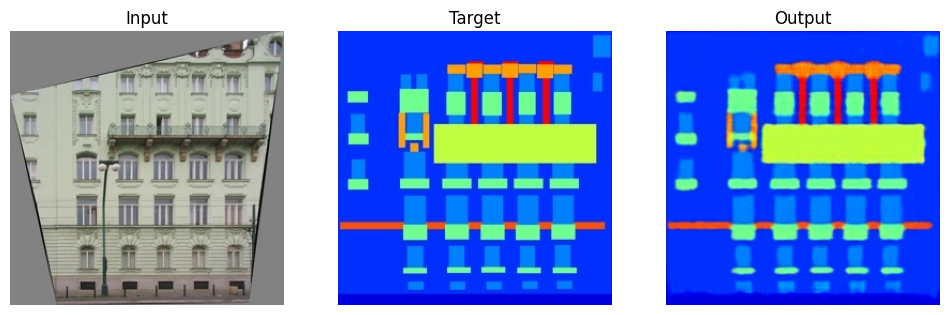

In [11]:
# test and visualisasi
def show_result(input_img, target, output):
    input_img = (input_img * 0.5 + 0.5).permute(1,2,0).cpu().detach().numpy()
    target    = (target    * 0.5 + 0.5).permute(1,2,0).cpu().detach().numpy()
    output    = (output    * 0.5 + 0.5).permute(1,2,0).cpu().detach().numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Input");  plt.imshow(input_img); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Target"); plt.imshow(target);    plt.axis("off")
    plt.subplot(1,3,3); plt.title("Output"); plt.imshow(output);    plt.axis("off")
    plt.show()

# Ambil 1 batch dari dataloader
inp, tar = next(iter(dataloader))
inp, tar = inp.to(device), tar.to(device)

# Inference mode
model.eval()
with torch.no_grad():
    out = model(inp)

show_result(inp[0], tar[0], out[0])

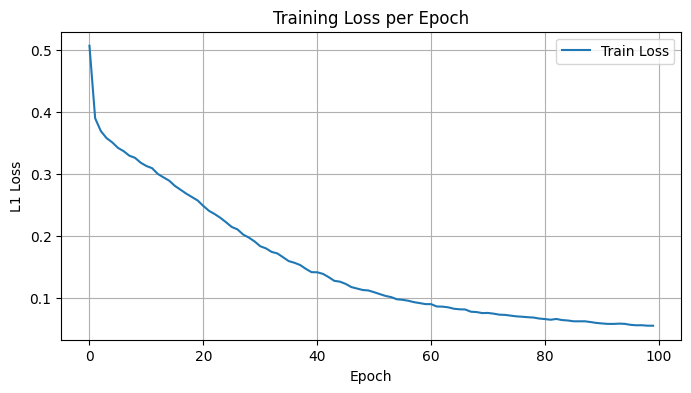

In [12]:
# plot loss
plt.figure(figsize=(8,4))
plt.plot(loss_history, label="Train Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# save model
SAVE_DIR = "/content/drive/MyDrive/DeepLearningGSLC2/pix2pix_results/"
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(model.state_dict(), SAVE_DIR + "pix2pix_unet.pth")
print("Model saved!")

Model saved!


input: foto bangunan asli

target: segmentasi facade (kelas seperti jendela, pintu, atap, dinding, dll)

output: hasil prediksi model setelah 100 epoch

model berhasil mengenali layout keseluruhan bangunan, memahami posisi jendela, memetakan lokasi pintu, memetakan atap. artinya skip connection pada model bekerja dengan baik dalam mempertahankan spatial structure. model telah memperlajari korelasi antara bentuk objek di input dan labelnya, artinya model juga berhasil mempelajari mapping dari citra natural -> citra segmentasi warna, namun masih kurang presisi karena warna masih blur.

hasil tanpa menggunakan GAN jauh lebih bagus di bandingkan dengan menggunakan GAN. tanpa GAN output yang dihasilkan lebih stabil, lbih mirip target dan blur bentuknya lebih mendekati aslinya.
dengan GAN output yang di hasilkan lebih noicy, warna kacau dan sulit konvergen

hal ini dikarenakan GAN memberikan tekanan realism yang tidak diperlukan, GAN mencoba membuat output terlihat seperti gambar aslinya, sehinga lebih cocok untuk photo -> photo (data pixel to pixel regression) sehingga sedikit kurang cocok dengan dataset, GAN berusaha menilai apakah output realistis, padahal segmentasi mask tidak punya tekstur alami, warnanya jadi flat & blok blok, tidak ada detail high frequency seperti foto. karena output segmentasi warna tidak menyerupai foto realistis, sehingga memperlajari pola yang salah. generator di paksa membuat noise untuk mengelabui, menambah noice kecil, grid, tekstur palsu sehingg outputnya berbintik bintik, bergaris, warna tidak stabil. dataset ini juga tergolong kecil. GAN menambahkan texture pressure, padahal segmentasi mask tidak punya tekstur.
l1 + U-NET, sangat sesuai untuk segmentasi, karena U-NET memang didesign untuk: mempertahankan struktur spasial (karena skip connections), memetakan bentuk objek -> mask, membuat pembagian area yang rapi, sehingga model dapat mengenali fitur fitur yang ada.